In [1]:
import pandas as pd
import torch
from transformers import RobertaModel, RobertaTokenizerFast, BertModel, BertTokenizerFast
import os
import numpy as np
# df = pd.read_csv("Z:/Code/Negative_Constructions/data/epistemic.txt",sep="\t")
# os.listdir("Z:/Code/Negative_Constructions/data/")

### Negation NLI

In [5]:
import pandas as pd
path = "/home/a/alaverghett/from_source/negation-psycholinguistics/scripts/developmental-negation/parse_nli/nli_datasets/for_parser/"
files = os.listdir(path)
files = [f for f in files if "negation" in f]
files = files[:-1]

files

['snli_1.0_dev_cleaned.jsonl_negation.jsonl',
 'snli_1.0_test_cleaned.jsonl_negation.jsonl',
 'snli_1.0_train_cleaned.jsonl_negation.jsonl',
 'multinli_1.0_train.jsonl_negation.jsonl',
 'multinli_1.0_dev_matched_cleaned.jsonl_negation.jsonl']

In [6]:
df = pd.DataFrame()
for f in files:
    temp = pd.read_json(path + f,lines=True,orient="records")
    df = df.append(temp)

In [7]:
df.drop(columns=['sentence1_parse','sentence1_binary_parse','sentence2_parse','sentence2_binary_parse'],inplace=True)
df.columns

Index(['annotator_labels', 'captionID', 'gold_label', 'pairID', 'sentence1',
       'sentence2', 'posession', 'existence', 'labeling', 'prohibition',
       'inability', 'epistemic', 'rejection', 'genre', 'promptID'],
      dtype='object')

In [8]:
df['posession'].value_counts()

0    969977
1      1573
Name: posession, dtype: int64

In [9]:
df['existence'].value_counts()

0    963299
1      8251
Name: existence, dtype: int64

In [10]:
df['labeling'].value_counts()

0    971124
1       426
Name: labeling, dtype: int64

In [11]:
df['prohibition'].value_counts()

0    971368
1       182
Name: prohibition, dtype: int64

In [12]:
df['inability'].value_counts()

0    969484
1      2066
Name: inability, dtype: int64

In [13]:
df['epistemic'].value_counts()

0    968711
1      2839
Name: epistemic, dtype: int64

In [14]:
df['rejection'].value_counts()

0    968957
1      2593
Name: rejection, dtype: int64

In [22]:
df[['rejection','epistemic','labeling','prohibition','inability','existence','posession']].astype(bool).any(axis=1).astype(int).sum()

17923

In [24]:
df.to_json("/home/a/alaverghett/from_source/negation-psycholinguistics/scripts/developmental-negation/parse_nli/nli_datasets/for_parser/negation_nli_dataset_full_v3.json",lines=True,orient="records")

### Create new splits of the combined NLI dataset

In [19]:
df.drop(columns=['sentence1_binary_parse','sentence1_parse','sentence2_binary_parse','sentence2_parse'],inplace=True)

In [20]:
train = df.loc[(df['posession'] == 0) & (df['existence'] == 0) & (df['labeling'] == 0) & (df['prohibition'] == 0) & (df['inability'] == 0) & (df['epistemic'] == 0) & (df['rejection'] == 0)]

In [15]:
test = df.loc[(df['posession'] == 1) | (df['existence'] == 1) | (df['labeling'] == 1) | (df['prohibition'] == 1) | (df['inability'] == 1) | (df['epistemic'] == 1) | (df['rejection'] == 1)]

In [23]:
# to prevent data leakage, remove all examples which contain explicit negation
train = train.loc[~(train["sentence1"].str.contains("no")) & ~(train["sentence1"].str.contains("not")) & ~(train["sentence1"].str.contains("n't")) & ~(train["sentence2"].str.contains("no")) & ~(train["sentence2"].str.contains("not")) & ~(train["sentence2"].str.contains("n't"))]

In [18]:
len(test)

16969

In [ ]:
g = train.groupby('gold_label')
dev = pd.DataFrame(g.apply(lambda x : x.sample(3000).reset_index()).reset_index(drop=True))
dev

In [ ]:
train.drop(columns='annotator_labels',inplace=True)


In [ ]:
train_new = train.merge(dev,how='left',indicator=True)
train_new = train_new[train_new['_merge'] == 'left_only']

In [ ]:
train_new.drop(columns='_merge',inplace=True)
train_new

In [ ]:
dev

In [ ]:
test

In [18]:
# train.to_json("/home/antonio/from_source/negation-psycholinguistics/scripts/developmental-negation/parse_nli/nli_datasets/nli_negation_train.json",lines=True,orient='records')
# dev.to_json("/home/antonio/from_source/negation-psycholinguistics/scripts/developmental-negation/parse_nli/nli_datasets/nli_negation_dev.json",lines=True,orient='records')
test.to_json("/home/a/alaverghett/from_source/negation-psycholinguistics/scripts/developmental-negation/parse_nli/nli_datasets/nli_negation_test_v5.json",lines=True,orient='records')

In [28]:
test = pd.read_json("/home/a/alaverghett/from_source/negation-psycholinguistics/scripts/developmental-negation/parse_nli/nli_datasets/nli_negation_test_v5_wordnet_augmentation.json",lines=True,orient='records')
for cat in ['epistemic','existence','inability','labeling','posession','prohibition','rejection']:
    print(cat)
    print(test.loc[test[cat]==1]['gold_label'].value_counts())

epistemic
contradiction    1291
neutral           795
entailment        753
Name: gold_label, dtype: int64
existence
contradiction    6033
neutral          1185
entailment       1033
Name: gold_label, dtype: int64
inability
contradiction    1041
neutral           568
entailment        457
Name: gold_label, dtype: int64
labeling
contradiction    1911
entailment       1085
neutral           349
Name: gold_label, dtype: int64
posession
contradiction    926
entailment       326
neutral          321
Name: gold_label, dtype: int64
prohibition
contradiction    865
neutral          256
entailment        93
Name: gold_label, dtype: int64
rejection
neutral          1048
contradiction    1001
entailment        544
Name: gold_label, dtype: int64


### Get graph of negation development

In [28]:
%matplotlib inline
path = "/home/a/alaverghett/from_source/negation-psycholinguistics/scripts/developmental-negation/checkpoint_results/BabyBERTa-1-one-epoch"
files = os.listdir(path)
files

['config.json',
 'pytorch_model.bin',
 'tokenizer_config.json',
 'special_tokens_map.json',
 'vocab.json',
 'merges.txt',
 'tokenizer.json',
 'training_args.bin',
 'model_args.json',
 'step-2000',
 'step-4000',
 'step-6000',
 'step-8000',
 'step-10000',
 'step-12000',
 'step-14000',
 'step-16000',
 'step-18000',
 'step-20000',
 'step-22000',
 'step-24000',
 'step-26000',
 'step-28000',
 'step-30000',
 'step-32000',
 'step-34000',
 'step-36000',
 'step-38000',
 'step-40000',
 'step-42000',
 'step-44000',
 'epoch-1',
 'eval_results.txt']

In [29]:
import pandas as pd
# babyberta-1-epoch
cats = ['possession','existence','labeling','prohibition','inability','epistemic','rejection']
# models = ['BabyBERTa-1','roberta-base-10M-2','bert-base-cased','bert-large-cased','roberta-base','roberta-large']
models = ['BabyBERTa-1-one-epoch','bert-base-cased-one-epoch']
scores = {}
for m in models:
    epoch = 1
    scores[m] = {}
    for f in range(1,22):
        str_epoch = f"epoch-{epoch}"
        scores[m][epoch] = {}
        # f = [f for f in files if str_epoch in f]
        # print(f)
        for c in cats:
            if c == 'possession':
                # df = pd.read_csv(path + "/" + str_epoch + "/" + "posession_innoculation_test_v3.csv")
                df = pd.read_csv(f"/home/a/alaverghett/from_source/negation-psycholinguistics/scripts/developmental-negation/checkpoint_results/{m}/step-{epoch*2000}/challenge_nli_experiment1_step-{epoch*2000}.csv")
                acc = df.loc[df['posession'] == 1]['Correct'].mean()
                scores[m][epoch][c] = acc
            else:
                # df = pd.read_csv(path + "/" + str_epoch + "/" + c + "_innoculation_test_v3.csv")
                df = pd.read_csv(f"/home/a/alaverghett/from_source/negation-psycholinguistics/scripts/developmental-negation/checkpoint_results/{m}/step-{epoch*2000}/challenge_nli_experiment1_step-{epoch*2000}.csv")
                acc = df.loc[df[c] == 1]['Correct'].mean()
                scores[m][epoch][c] = acc
        epoch += 1

scores

{'BabyBERTa-1-one-epoch': {1: {'possession': 0.20470438652256834,
   'existence': 0.15101199854563083,
   'labeling': 0.2591928251121076,
   'prohibition': 0.21252059308072488,
   'inability': 0.2749273959341723,
   'epistemic': 0.29306093694963015,
   'rejection': 0.38758195140763596},
  2: {'possession': 0.2193261284170375,
   'existence': 0.15501151375590838,
   'labeling': 0.24035874439461882,
   'prohibition': 0.20593080724876442,
   'inability': 0.2967086156824782,
   'epistemic': 0.3015146178231772,
   'rejection': 0.3945237177015041},
  3: {'possession': 0.2193261284170375,
   'existence': 0.15476911889467942,
   'labeling': 0.25530642750373694,
   'prohibition': 0.16474464579901152,
   'inability': 0.29864472410454984,
   'epistemic': 0.30715040507220853,
   'rejection': 0.38488237562668726},
  4: {'possession': 0.2263191354100445,
   'existence': 0.16628287480305418,
   'labeling': 0.3052316890881913,
   'prohibition': 0.25370675453047775,
   'inability': 0.31413359148112296,

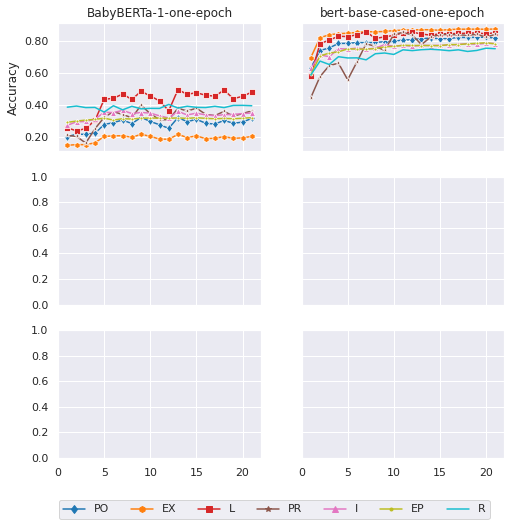

In [14]:
import seaborn as sns
# sns.set_theme()
from matplotlib import pyplot as plt
import matplotlib
from itertools import product
plt.rc('legend',fontsize=10)
plt.rc('axes',labelsize=16)
plt.rc('axes',titlesize=16)
plt.rc('xtick',labelsize=12)
plt.rc('ytick',labelsize=12)

sns.set()
# with sns.axes_style(style='darkgrid'):

fig, axes = plt.subplots(3, 2, sharex='all', sharey='row', figsize=(8,8))
cat_markers = ['PO','EX','L','PR','I','EP','R']
# axes.yaxis.set_major_formatter('{x:9<5.1f}')
plot_locs = list(product([0,1,2],[0,1]))


for i,m in enumerate(models):
    colors = ['#1f77b4', '#ff7f0e', '#d62728', '#8c564b', '#e377c2', '#bcbd22', '#17becf']
    plot_scores = pd.DataFrame(scores[m])
    lines = []
    markers = ["d","h","s","*","^",".","None"]
    cats = ['possession','existence','labeling','prohibition','inability','epistemic','rejection']
    for index in range(len(plot_scores)):
        # print(f"{plot_scores.iloc[index].name}: {colors[index]}")
        # ax = plt.plot(x,model_1[cat],color=colors[index],marker=markers[index])
        # axes[plot_locs[i][0],plot_locs[i][1]].plot(plot_scores.iloc[index].index,plot_scores.iloc[index].values,marker=markers[index],color=colors[index])
        sns.lineplot(ax=axes[plot_locs[i][0],plot_locs[i][1]],x=plot_scores.iloc[index].index,y=plot_scores.iloc[index].values,marker=markers[index],color=colors[index])
        # sns.lineplot(ax=(i,1),x=plot_scores.iloc[index].index,y=plot_scores.iloc[index].values,marker=markers[index],color=colors[index])
        axes[plot_locs[i][0],plot_locs[i][1]].yaxis.set_major_formatter('{x:.2f}')
        axes[plot_locs[i][0],plot_locs[i][1]].set(xlabel="Epoch",ylabel="Accuracy")
        lines.append(matplotlib.lines.Line2D(plot_scores.iloc[index].index,plot_scores.iloc[index].values,marker=markers[index],color=colors[index]))
        # axes.append(ax[0])

    axes[plot_locs[i][0],plot_locs[i][1]].set_title(m)
    # plt.xlabel("Epoch")
    # plt.ylabel("Accuracy")
    # plt.title("BabyBERTa-1 Base")

# add a big axis, hide frame
# ax = fig.add_subplot(111, frameon=False)
# # hide tick and tick label of the big axis
# plt.tick_params(labelcolor='none', which='both', top=False, bottom=False, left=False, right=False)
# plt.xlabel("Epoch")
# plt.ylabel("Accuracy")
# ax.yaxis.set_label_coords(-.09,.5)
fig.legend(lines,cat_markers,loc='lower center',ncol=7, bbox_to_anchor=(0.5,0.01,0,0))
plt.savefig("experiment_1.png",dpi=400,bbox_inches="tight")

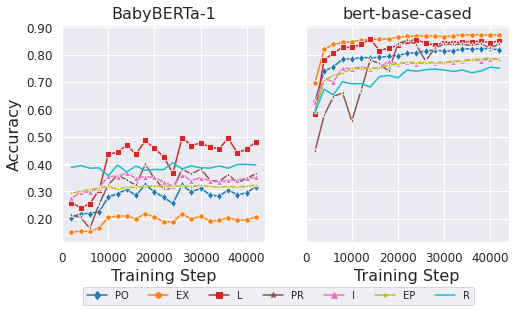

In [30]:
import seaborn as sns
sns.set_theme()
from matplotlib import pyplot as plt
import matplotlib
from itertools import product
plt.rc('legend',fontsize=10)
plt.rc('axes',labelsize=16)
plt.rc('axes',titlesize=16)
plt.rc('xtick',labelsize=12)
plt.rc('ytick',labelsize=12)

x = [2000,4000,6000,8000,10000,12000,14000,16000,18000,20000,22000,24000,26000,28000,30000,32000,34000,36000,38000,40000,42000]
cat_markers = ['PO','EX','L','PR','I','EP','R']

fig, axes = plt.subplots(1, 2, sharex='all', sharey='row', figsize=(8,4))
# # axes.yaxis.set_major_formatter('{x:9<5.1f}')
plot_locs = [0,1]

for i,m in enumerate(models):
    colors = ['#1f77b4', '#ff7f0e', '#d62728', '#8c564b', '#e377c2', '#bcbd22', '#17becf']
    plot_scores = pd.DataFrame(scores[m])
    lines = []
    markers = ["d","h","s","*","^",".","None"]
    cats = ['possession','existence','labeling','prohibition','inability','epistemic','rejection']

    for index in range(len(plot_scores)):
    # print(f"{plot_scores.iloc[index].name}: {colors[index]}")
        # plt.plot(x,plot_scores.iloc[index].values,color=colors[index],marker=markers[index])
        # axes[plot_locs[i]].plot(x,plot_scores.iloc[index].values,marker=markers[index],color=colors[index])
        sns.lineplot(ax=axes[plot_locs[i]],x=x,y=plot_scores.iloc[index].values,marker=markers[index],color=colors[index])
        axes[plot_locs[i]].yaxis.set_major_formatter('{x:.2f}')
        axes[plot_locs[i]].set(xlabel="Training Step",ylabel="Accuracy")
        lines.append(matplotlib.lines.Line2D(plot_scores.iloc[index].index,plot_scores.iloc[index].values,marker=markers[index],color=colors[index]))

    if 'baby' in m.lower():
        axes[plot_locs[i]].set_title('BabyBERTa-1')
    else:
        axes[plot_locs[i]].set_title('bert-base-cased')
    # plt.xlabel("Epoch")
    # plt.ylabel("Accuracy")
    # plt.title("BabyBERTa-1")

fig.legend(lines,cat_markers,loc='lower center',ncol=7, bbox_to_anchor=(0.5,-0.11,0,0))
plt.savefig("experiment_1_1epoch.png",dpi=400,bbox_inches="tight")

In [21]:
# new version of experiment 2
import pandas as pd
from os import path
pth = "/home/a/alaverghett/from_source/negation-psycholinguistics/scripts/developmental-negation/checkpoint_results/"
models = ["BabyBERTa-1","roberta-base-10M-2","roberta-base","roberta-large","bert-base-cased","bert-large-cased"]
# colors = ['green','violet','purple','gold','chocolate','lime','brown']
colors = ['#1f77b4', '#ff7f0e', '#d62728', '#8c564b', '#e377c2', '#bcbd22', '#17becf']
markers = ["d","h","s","*","^",".","None"]
cats = ['posession','existence','labeling','prohibition','inability','epistemic','rejection']
finished_cats = ['posession','existence','labeling','prohibition','inability','epistemic','rejection']
scores = {}

for m in models:
    if "large" in m:
        epoch_i = 25
    else:
        epoch_i = 25
    diag = os.listdir(path.join(pth,m,'epoch-10'))
    diag = [d for d in diag if d in finished_cats]
    scores[m] = {}
    for d in diag:
        scores[m][d] = {}
        for epoch in range(0,epoch_i):
            scores[m][d][epoch] = {}
            results = os.listdir(path.join(pth,m,'epoch-10',d,f"epoch-{epoch+1}"))
            results = [r for r in results if ".csv" in r]
            for c in cats:
                cat_csv = [r for r in results if c in r][0]
                # if c == 'possession':
                #     df = pd.read_csv(results + "/" + f"posession_innoculation_test_v3.csv")
                #     acc = df.loc[df['posession'] == 1]['Correct'].sum() / len(df.loc[df['posession'] == 1])
                #     scores[d][epoch]['possession'] = acc
                # else:
                #     df = pd.read_csv(results + "/" + f"{c}_innoculation_test_v3.csv")
                #     acc = df.loc[df[c] == 1]['Correct'].sum() / len(df.loc[df[c] == 1])
                #     scores[d][epoch][c] = acc
                df = pd.read_csv(os.path.join(pth,m,'epoch-10',d,f"epoch-{epoch+1}",cat_csv))
                acc = df.loc[df[c] == 1]['Correct'].mean()
                scores[m][d][epoch][c] = acc

scores
# os.listdir(path)

{'BabyBERTa-1': {'epistemic': {0: {'posession': 0.475,
    'existence': 0.3995593095850165,
    'labeling': 0.5307971014492754,
    'prohibition': 0.24,
    'inability': 0.48533724340175954,
    'epistemic': 0.4423076923076923,
    'rejection': 0.4672897196261682},
   1: {'posession': 0.475,
    'existence': 0.41167829599706207,
    'labeling': 0.529891304347826,
    'prohibition': 0.25,
    'inability': 0.47947214076246336,
    'epistemic': 0.44551282051282054,
    'rejection': 0.4661214953271028},
   2: {'posession': 0.49230769230769234,
    'existence': 0.43444730077120824,
    'labeling': 0.5434782608695652,
    'prohibition': 0.29,
    'inability': 0.48826979472140764,
    'epistemic': 0.4497863247863248,
    'rejection': 0.4614485981308411},
   3: {'posession': 0.5057692307692307,
    'existence': 0.4612559676827029,
    'labeling': 0.5661231884057971,
    'prohibition': 0.3175,
    'inability': 0.4941348973607038,
    'epistemic': 0.4551282051282051,
    'rejection': 0.468457943

In [25]:
# experiment 3
import pandas as pd
from os import path
pth = "/home/a/alaverghett/from_source/negation-psycholinguistics/scripts/developmental-negation/checkpoint_results/"
models = ["BabyBERTa-1","roberta-base-10M-2","roberta-base","roberta-large","bert-base-cased","bert-large-cased"]
# colors = ['green','violet','purple','gold','chocolate','lime','brown']
colors = ['#1f77b4', '#ff7f0e', '#d62728', '#8c564b', '#e377c2', '#bcbd22', '#17becf']
markers = ["d","h","s","*","^",".","None"]
cats = ['posession','existence','labeling','prohibition','inability','epistemic','rejection']
finished_cats = ['posession','existence','labeling','prohibition','inability','epistemic','rejection']
scores = {}

for m in models:
    epoch_i = 10
    diag = os.listdir(path.join(pth,m,'epoch-10','experiment-3'))
    diag = [d for d in diag if d in finished_cats]
    scores[m] = {}
    for d in diag:
        scores[m][d] = {}
        results = os.listdir(path.join(pth,m,'epoch-10','experiment-3',d,"epoch-10"))
        results = [r for r in results if ".csv" in r]
        for c in cats:
            cat_csv = [r for r in results if c in r][0]
            # if c == 'possession':
            #     df = pd.read_csv(results + "/" + f"posession_innoculation_test_v3.csv")
            #     acc = df.loc[df['posession'] == 1]['Correct'].sum() / len(df.loc[df['posession'] == 1])
            #     scores[d][epoch]['possession'] = acc
            # else:
            #     df = pd.read_csv(results + "/" + f"{c}_innoculation_test_v3.csv")
            #     acc = df.loc[df[c] == 1]['Correct'].sum() / len(df.loc[df[c] == 1])
            #     scores[d][epoch][c] = acc
            df = pd.read_csv(os.path.join(pth,m,'epoch-10','experiment-3',d,"epoch-10",cat_csv))
            acc = df.loc[df[c] == 1]['Correct'].mean()
            scores[m][d][c] = acc

scores
# os.listdir(path)

{'BabyBERTa-1': {'epistemic': {'posession': 0.5,
   'existence': 0.4454645611457951,
   'labeling': 0.5570652173913043,
   'prohibition': 0.28,
   'inability': 0.49560117302052786,
   'epistemic': 0.4519230769230769,
   'rejection': 0.4719626168224299},
  'existence': {'posession': 0.5057692307692307,
   'existence': 0.5460888725670217,
   'labeling': 0.5833333333333334,
   'prohibition': 0.32,
   'inability': 0.5102639296187683,
   'epistemic': 0.452991452991453,
   'rejection': 0.4696261682242991},
  'rejection': {'posession': 0.525,
   'existence': 0.565919941241278,
   'labeling': 0.5788043478260869,
   'prohibition': 0.3275,
   'inability': 0.49853372434017595,
   'epistemic': 0.4668803418803419,
   'rejection': 0.47897196261682246},
  'posession': {'posession': 0.5461538461538461,
   'existence': 0.6033786265148733,
   'labeling': 0.5887681159420289,
   'prohibition': 0.3725,
   'inability': 0.5058651026392962,
   'epistemic': 0.469017094017094,
   'rejection': 0.4742990654205608

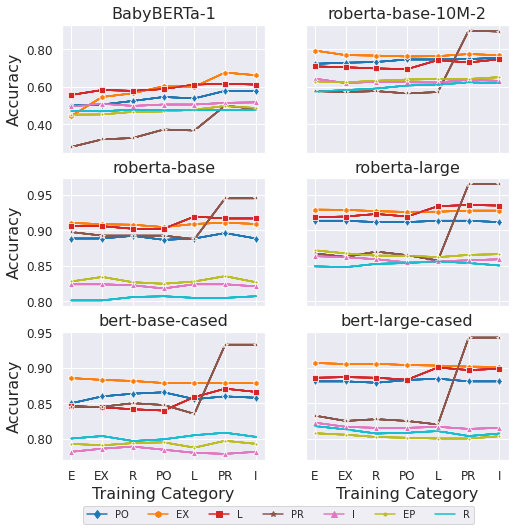

In [28]:
# the code can be used either for experiment 2 or experiment 3

import seaborn as sns
sns.set_theme()
from matplotlib import pyplot as plt
import matplotlib
from itertools import product
plt.rc('legend',fontsize=10)
plt.rc('axes',labelsize=16)
plt.rc('axes',titlesize=16)
plt.rc('xtick',labelsize=12)
plt.rc('ytick',labelsize=12)

experiment_3 = True


# experiment 3
if experiment_3:
    x = ['E','EX','R','PO','L','PR','I']

markers = ["d","h","s","*","^",".","None"]
cats = ['possession','existence','labeling','prohibition','inability','epistemic','rejection']
cat_markers = ['PO','EX','L','PR','I','EP','R']
colors = ['#1f77b4', '#ff7f0e', '#d62728', '#8c564b', '#e377c2', '#bcbd22', '#17becf']
line_sty = ['solid','dotted','dashed','dashdot','dotted','dashed','solid']

if experiment_3:
    fig, axes = plt.subplots(3, 2, sharex='all', sharey='row', figsize=(8,8))
else:
    fig, axes = plt.subplots(3, 2, sharex='all', sharey='row', figsize=(8,8))

# axes.yaxis.set_major_formatter('{x:9<5.1f}')
plot_locs = list(product([0,1,2],[0,1]))

for i,m in enumerate(models):
    plot_scores = scores[m]
    lines = []
    for sc_cat in plot_scores.keys():
        if experiment_3:
            test = pd.DataFrame(plot_scores)
        else:
            test = pd.DataFrame(plot_scores[sc_cat])     
        for j,index in enumerate(range(len(test))):
            # print(f"{test.iloc[index].name}: {colors[index]}")
            if experiment_3:
                # axes[plot_locs[i][0],plot_locs[i][1]].plot(x,test.iloc[index].values,marker=markers[index],color=colors[index])
                sns.lineplot(ax=axes[plot_locs[i][0],plot_locs[i][1]],x=x,y=test.iloc[index].values,marker=markers[index],color=colors[index])
                lines.append(matplotlib.lines.Line2D(x,test.iloc[index].values,marker=markers[index],linestyle=None,color=colors[index]))
                axes[plot_locs[i][0],plot_locs[i][1]].set(xlabel="Training Category",ylabel="Accuracy")
            else:
                # axes[plot_locs[i][0],plot_locs[i][1]].plot(test.iloc[index].index,test.iloc[index].values,marker=None,linestyle=line_sty[index],color=colors[index])
                sns.lineplot(ax=axes[plot_locs[i][0],plot_locs[i][1]],x=test.iloc[index].index,y=test.iloc[index].values,marker=None,linestyle=line_sty[index],color=colors[index])
                lines.append(matplotlib.lines.Line2D(test.iloc[index].index,test.iloc[index].values,marker=None,linestyle=line_sty[index],color=colors[index]))
                axes[plot_locs[i][0],plot_locs[i][1]].set(xlabel="Epoch",ylabel="Accuracy")
            axes[plot_locs[i][0],plot_locs[i][1]].yaxis.set_major_formatter('{x:.2f}')
            
            

        axes[plot_locs[i][0],plot_locs[i][1]].set_title(m)
        # plt.xlabel("Epoch")
        # plt.ylabel("Accuracy")


fig.legend(lines,cat_markers,loc='lower center',ncol=7, bbox_to_anchor=(0.5,0.005,0,0))

if experiment_3:
    plt.savefig("experiment-3.png",dpi=300,bbox_inches="tight")
else:
    plt.savefig("experiment-2.png",dpi=300,bbox_inches="tight")

In [47]:
plot_scores

{'epistemic': {'posession': 0.7230769230769231,
  'existence': 0.7936099889827396,
  'labeling': 0.7092391304347826,
  'prohibition': 0.5775,
  'inability': 0.6436950146627566,
  'epistemic': 0.6282051282051282,
  'rejection': 0.5747663551401869},
 'existence': {'posession': 0.7288461538461538,
  'existence': 0.7693720161586486,
  'labeling': 0.7047101449275363,
  'prohibition': 0.5725,
  'inability': 0.6202346041055719,
  'epistemic': 0.6239316239316239,
  'rejection': 0.5829439252336449},
 'rejection': {'posession': 0.7326923076923076,
  'existence': 0.766801322071245,
  'labeling': 0.6983695652173914,
  'prohibition': 0.5775,
  'inability': 0.6275659824046921,
  'epistemic': 0.6324786324786325,
  'rejection': 0.5911214953271028},
 'posession': {'posession': 0.7461538461538462,
  'existence': 0.762027175908924,
  'labeling': 0.6947463768115942,
  'prohibition': 0.565,
  'inability': 0.624633431085044,
  'epistemic': 0.6388888888888888,
  'rejection': 0.6074766355140186},
 'labeling':

In [43]:
# experimental graph
import seaborn as sns
from matplotlib import pyplot as plt
sns.set_theme()
# colors = ['green','violet','purple','gold','chocolate','lime','brown']
markers = ["d","h","s","*","^",".","None"]
cats = ['posession','existence','labeling','prohibition','inability','epistemic','rejection']
# cats = ['posession','existence']
axes = []
plt.rc('legend',fontsize=14)
plt.rc('axes',labelsize=16)
plt.rc('axes',titlesize=16)
plt.rc('xtick',labelsize=12)
plt.rc('ytick',labelsize=12)

mean_graphs = {
    'rejection':None,
    'posession':None,
    'existence':None,
    'labeling':None,
    'prohibition':None,
    'inability':None,
    'epistemic':None
}


for i,sc in enumerate(scores.keys()):
    test = pd.DataFrame(scores[sc])
    scores = pd.DataFrame()
    for j,index in enumerate(range(len(test))):
        scores[] = test.iloc[index]
        



        
    # plt.legend(axes,scores['posession_innoculation_v2.jsonl'][0].keys(),loc='best',bbox_to_anchor=(0.9,0.53,0.5,0.5))
# plt.savefig("bert-large-all-finetuning-checkpoints.png",dpi=300,bbox_inches="tight")

array([0.81074766, 0.80841121, 0.80724299, 0.80490654, 0.80724299,
       0.80957944, 0.80607477, 0.80724299, 0.80373832, 0.80140187,
       0.80023364, 0.80023364, 0.80023364, 0.79906542, 0.80023364,
       0.7978972 , 0.80140187, 0.80257009, 0.80140187, 0.79906542,
       0.7978972 , 0.80023364, 0.79906542, 0.80023364, 0.80023364,
       0.80373832, 0.80140187, 0.80140187, 0.80373832, 0.80373832,
       0.80373832, 0.80607477, 0.80257009, 0.80023364, 0.80257009,
       0.80724299, 0.80841121, 0.80841121, 0.80607477, 0.81425234])

In [49]:
test[index].index

Index(['posession', 'existence', 'labeling', 'prohibition', 'inability',
       'epistemic', 'rejection'],
      dtype='object')

In [42]:
# pseduo test set
path = "/home/antonio/from_source/negation-psycholinguistics/scripts/developmental-negation/checkpoint_results/diagnostic_results/pseudo_test/test_9"
files = os.listdir(path)

FileNotFoundError: [Errno 2] No such file or directory: '/home/antonio/from_source/negation-psycholinguistics/scripts/developmental-negation/checkpoint_results/diagnostic_results/pseudo_test/test_9'

In [ ]:
from scipy.stats import spearmanr
columns = ['posession','existence','labeling','prohibition','inability','epistemic','rejection']
scores = pd.DataFrame(scores)
all_corrs = [[],[],[],[],[],[],[]]
all_ps = [[],[],[],[],[],[],[]]

# all_scores = [[],[],[],[],[],[],[]]

for test_i in range(0,100):
    path = f"/home/antonio/from_source/negation-psycholinguistics/scripts/developmental-negation/checkpoint_results/diagnostic_results/pseudo_test/test_{test_i}"
    files = os.listdir(path)

    epoch = 1
    pseduo_scores = {}
    for f in files:
        str_epoch = f"epoch-{epoch}.csv"
        pseduo_scores[epoch] = {}
        f = [f for f in files if str_epoch in f][0]
        # print(f)
        df = pd.read_csv(path + "/" + f)
        for c in columns:
            acc = df.loc[df[c] == 1]['Correct'].sum() / len(df.loc[df[c] == 1])
            pseduo_scores[epoch][c] = acc
        epoch += 1

    pseduo_scores = pd.DataFrame(pseduo_scores)
    for index in range(len(scores)):
        corr = spearmanr(scores.iloc[index].values[1:],pseduo_scores.iloc[index].values)
        all_corrs[index].append(corr[0])
        all_ps[index].append(corr[1])
        # print(f"{scores.iloc[index].name}: {corr}")

In [ ]:
all_corrs = np.asarray(all_corrs)
all_ps = np.asarray(all_ps)

print(np.mean(all_corrs,axis=1))
print(np.mean(all_ps,axis=1))

print(np.median(all_corrs,axis=1))
print(np.median(all_ps,axis=1))

print(np.var(all_corrs,axis=1))
print(np.var(all_ps,axis=1))

In [ ]:
# plot the mean pseudo_scores per category
colors = ['green','violet','purple','gold','chocolate','lime','brown']
markers = ["d","h","s","*","^",".","None"]
for index in range(len(pseduo_scores)):
    print(f"{pseduo_scores.iloc[index].name}: {colors[index]}")
    ax = sns.lineplot(y=pseduo_scores.iloc[index].values,x=pseduo_scores.iloc[index].index,color=colors[index],marker=markers[index]).set(title="Accuracy for each Negation Category")

plt.xlabel("Epoch")
plt.ylabel("Accuracy")

In [12]:
import pandas as pd
df = pd.read_json("/home/antonio/from_source/negation-psycholinguistics/scripts/developmental-negation/parse_nli/nli_datasets/to_parse/R3/train_negation.jsonl",lines=True,orient='records')
# df.rename({"context":"sentence1","hypothesis":"sentence2"},inplace=True,axis=1)
# df.to_json("/home/antonio/from_source/negation-psycholinguistics/scripts/developmental-negation/parse_nli/nli_datasets/to_parse/R3/train.jsonl",lines=True,orient='records')
df.columns

Index(['uid', 'sentence1', 'sentence2', 'label', 'model_label', 'emturk',
       'genre', 'reason', 'tag', 'posession', 'existence', 'labeling',
       'prohibition', 'inability', 'epistemic', 'rejection'],
      dtype='object')

In [24]:
df = pd.read_json("/home/antonio/from_source/negation-psycholinguistics/scripts/developmental-negation/parse_nli/nli_datasets/to_parse/anli_R1/train_negation.jsonl",lines=True,orient='records')
df.columns

Index(['uid', 'sentence1', 'sentence2', 'label', 'model_label', 'emturk',
       'genre', 'reason', 'tag', 'posession', 'existence', 'labeling',
       'prohibition', 'inability', 'epistemic', 'rejection'],
      dtype='object')

In [19]:
df['rejection'].value_counts()

0    99954
1      505
Name: rejection, dtype: int64

### Wikipedia pre-training data, standardize format and tokenize sentences

In [10]:
import multiprocessing as mp
from nltk.tokenize import sent_tokenize
import os
import numpy as np
import pandas as pd

# each process is passed a set of directories to process
# each directories contains multiple json files, each of which needs to be tokenized
# and combined with the master json dataset
def job(directories):    # new_df is a multiprocessing list
    new_df = pd.DataFrame()
    for directory in directories:
        for f in os.listdir(f"/raid/datasets/wikipedia-dump-September-2021/{directory}"):
            df = pd.read_json(f"/raid/datasets/wikipedia-dump-September-2021/{directory}/{f}",lines=True,orient='records')
            df = df.loc[df['text'] != ""]
            df['text'] = df['text'].apply(lambda x: sent_tokenize(x))
            df = df[df['text'].map(lambda x: len(x) > 0)]
            df = df.explode('text',ignore_index=True)
            new_df = new_df.append(df)

    
    # out_df = pd.concat(new_df,ignore_index=True)
    with open("/raid/datasets/wikipedia-dump-September-2021/wikipedia.jsonl", '+a') as file:
        new_df.to_json(file,lines=True,orient="records")
    
    new_df = None
    del new_df


dirs = os.listdir("/raid/datasets/wikipedia-dump-September-2021")

# d = mp.Manager().list([new_df])

splits = np.array_split(dirs,20)

p_1 = mp.Process(target=job,args=[splits[0]])
p_2 = mp.Process(target=job,args=[splits[1]])
p_3 = mp.Process(target=job,args=[splits[2]])
p_4 = mp.Process(target=job,args=[splits[3]])
p_5 = mp.Process(target=job,args=[splits[4]])
p_6 = mp.Process(target=job,args=[splits[5]])
p_7 = mp.Process(target=job,args=[splits[6]])
p_8 = mp.Process(target=job,args=[splits[7]])
p_9 = mp.Process(target=job,args=[splits[8]])
p_10 = mp.Process(target=job,args=[splits[9]])
p_11 = mp.Process(target=job,args=[splits[10]])
p_12 = mp.Process(target=job,args=[splits[11]])
p_13 = mp.Process(target=job,args=[splits[12]])
p_14 = mp.Process(target=job,args=[splits[13]])
p_15 = mp.Process(target=job,args=[splits[14]])
p_16 = mp.Process(target=job,args=[splits[15]])
p_17 = mp.Process(target=job,args=[splits[16]])
p_18 = mp.Process(target=job,args=[splits[17]])
p_19 = mp.Process(target=job,args=[splits[18]])
p_20 = mp.Process(target=job,args=[splits[19]])

p_1.start()
p_2.start()
p_3.start()
p_4.start()
p_5.start()
p_6.start()
p_7.start()
p_8.start()
p_9.start()
p_10.start()

p_11.start()
p_12.start()
p_13.start()
p_14.start()
p_15.start()
p_16.start()
p_17.start()
p_18.start()
p_19.start()
p_20.start()

p_1.join()
p_2.join()
p_3.join()
p_4.join()
p_5.join()
p_6.join()
p_7.join()
p_8.join()
p_9.join()
p_10.join()

p_11.join()
p_12.join()
p_13.join()
p_14.join()
p_15.join()
p_16.join()
p_17.join()
p_18.join()
p_19.join()
p_20.join()

Process Process-1:
Traceback (most recent call last):
  File "/home/antonio/anaconda3/envs/transformers/lib/python3.8/multiprocessing/process.py", line 315, in _bootstrap
    self.run()
  File "/home/antonio/anaconda3/envs/transformers/lib/python3.8/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "<ipython-input-10-086e69158c7b>", line 13, in job
    for f in os.listdir(f"/raid/datasets/wikipedia-dump-September-2021/{directory}"):
NotADirectoryError: [Errno 20] Not a directory: '/raid/datasets/wikipedia-dump-September-2021/enwiki-20210901-pages-articles-multistream.xml'


### Analyze negation prevalence in book corpus

In [26]:
# NOTE: this cell will take a long time and use approximately 125gb of memory
book_corpus = pd.read_json("/raid/datasets/bookcorpus/train_negation.jsonl",lines=True,orient="records")
book_corpus.head()

,sentence1,posession,existence,labeling,prohibition,inability,epistemic,rejection
0,the half-ling book one in the fall of igneeria...,0,0,0,0,0,0,0
1,isbn : 1492913731 isbn-13 : 978-1492913733 for...,0,0,0,0,0,0,0
2,i wish i had a better answer to that question .,0,0,0,0,0,0,0
3,"starlings , new york is not the place youd exp...",0,0,0,0,0,0,0
4,"its a small quiet town , the kind where everyo...",0,0,0,0,0,0,0


In [1]:
# we will store the ranking in this df
# all_negations = pd.DataFrame(columns=['posession','existence','labeling','prohibition','inability','epistemic','rejection'])
all_negations = {'posession':0,'existence':0,'labeling':0,'prohibition':0,'inability':0,'epistemic':0,'rejection':0}

In [28]:
all_negations['posession'] = book_corpus['posession'].value_counts().iloc[1] 

In [29]:
all_negations['existence'] = book_corpus['existence'].value_counts().iloc[1]

In [30]:
all_negations['labeling'] = book_corpus['labeling'].value_counts().iloc[1]

In [31]:
all_negations['prohibition'] = book_corpus['prohibition'].value_counts().iloc[1]

In [32]:
all_negations['inability'] = book_corpus['inability'].value_counts().iloc[1]

In [33]:
all_negations['epistemic'] = book_corpus['epistemic'].value_counts().iloc[1]

In [34]:
all_negations['rejection'] = book_corpus['rejection'].value_counts().iloc[1]

In [35]:
# save the file, then restart the cell to clear the memory held by bookcorpus
all_negations = pd.Series(all_negations)
all_negations.sort_values(ascending=False)

existence      336783
rejection      227896
epistemic      213600
prohibition    150268
posession       52518
inability       27368
labeling         3947
dtype: int64

In [36]:
all_negations.to_json("/home/antonio/from_source/negation-psycholinguistics/scripts/developmental-negation/parse_nli/bookcorpus_negations.json",lines=False,orient="index")

In [3]:
all_negations = pd.read_json("/home/antonio/from_source/negation-psycholinguistics/scripts/developmental-negation/parse_nli/bookcorpus_negations.json",lines=False,orient="index")

In [4]:
# now parse wikipedia, or cc news
import os
path = "/raid/datasets/wikipedia-dump-September-2021/"
files = os.listdir(path)
files.remove("wikipedia.jsonl")
len(files)

20

In [5]:
import pandas as pd
all_negations = pd.Series(all_negations)
keys = ['existence','rejection','epistemic','prohibition','posession','inability','labeling']

for file in files:
    wiki_df = pd.read_json(path + "/" + file,lines=True,orient="records")
    for key in keys:
        neg_count = len(wiki_df.loc[wiki_df[key] == 1])
        # if neg_count > 0:
        #     print("here")
        all_negations.loc[key] += neg_count

In [6]:
all_negations

posession        9217
existence      151493
labeling          480
prohibition       885
inability       16754
epistemic        5755
rejection       13438
dtype: int64

Text(0.5, 1.0, 'Frequency of Negation Types in Wikipedia')

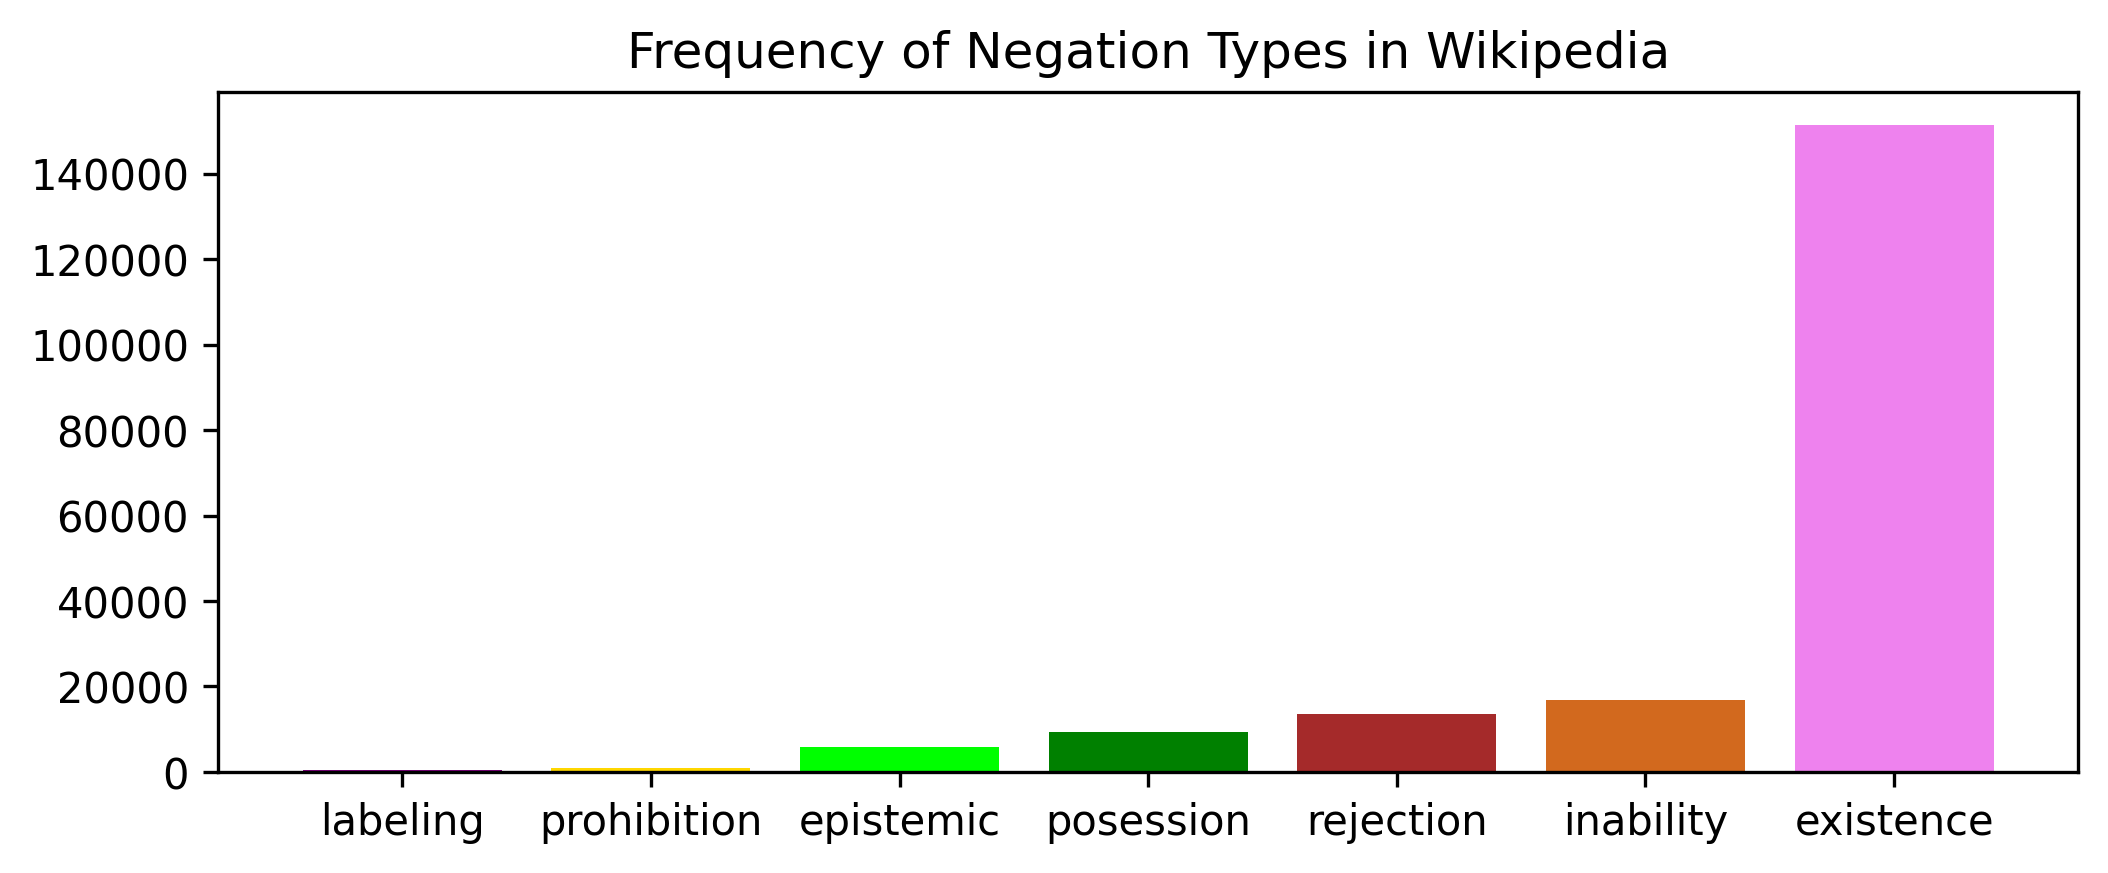

In [12]:
from matplotlib import pyplot as plt
from matplotlib.pyplot import figure
figure(figsize=(8,3),dpi=300)
# colors = ['purple','chocolate','green','gold','lime','brown','violet']  # for bookcorpus
# colors = ['purple','gold','green','brown','chocolate','lime','violet']   # for cc news
colors = ['purple','gold','lime','green','brown','chocolate','violet'] # for wikipedia

# colors = ['green','violet','purple','gold','chocolate','lime','brown']
# columns = ['posession','existence','labeling','prohibition','inability','epistemic','rejection']
all_negations = all_negations.sort_values() # by=0
plt.bar(x=all_negations.index,height=all_negations.values.flatten(),color=colors,)
plt.title("Frequency of Negation Types in Wikipedia")

### Perform the same pre-training experiments on the cc-news corpus

In [1]:
from datasets import load_dataset

news = load_dataset('cc_news', split='train')
news

Dataset cc_news downloaded and prepared to /home/antonio/.cache/huggingface/datasets/cc_news/plain_text/1.0.0/6cdde8d7fdaae3e50fb61b5d08d5387c2f0bbea1ee68755ef954af539a6a3a1b. Subsequent calls will reuse this data.


Dataset({
    features: ['title', 'text', 'domain', 'date', 'description', 'url', 'image_url'],
    num_rows: 708241
})

In [4]:
news = news.to_pandas()
news = news[['title','text','domain','url']]
news

,title,text,domain,url
0,"Prince Search Warrants Unsealed, Answer Few Qu...",By Abby Hassler\nOfficials unsealed court docu...,1041jackfm.cbslocal.com,http://1041jackfm.cbslocal.com/2017/04/17/prin...
1,Green Day’s Billie Joe Armstrong Rails Against...,By Abby Hassler\nGreen Day’s Billie Joe Armstr...,1041jackfm.cbslocal.com,http://1041jackfm.cbslocal.com/2017/08/14/bill...
2,Upcoming ‘Carpool Karaoke’ Series Looks Epic,By Hayden Wright\nA trailer has been released ...,1041jackfm.cbslocal.com,http://1041jackfm.cbslocal.com/2017/02/15/carp...
3,Mariah Carey Reacts to Her NYE Performance wit...,"By Brian Ives\nSo, you’re Mariah Carey, one of...",1041jackfm.cbslocal.com,http://1041jackfm.cbslocal.com/2017/01/01/mari...
4,Queen Release Alternate Takes of Classic Songs...,"By Hayden Wright\nLast month, Queen announced ...",1041jackfm.cbslocal.com,http://1041jackfm.cbslocal.com/2017/10/06/quee...
...,...,...,...,...
708236,SOCIAL SERVICES MINISTER OPENS INAUGURAL EQUAL...,The Bahamas Government will not renege on its ...,zns.moonfruit.com,http://zns.moonfruit.com/news/4578190248/SOCIA...
708237,Day 5: Lessons learnt from ‘Time’,Join the October writing challenge\n***\nI’ve ...,zoyakubra.wordpress.com,https://zoyakubra.wordpress.com/2017/10/05/les...
708238,"Day 6 - Heer Saleti, in pursuit of things ‘to do’",Read all previous posts from the October writi...,zoyakubra.wordpress.com,https://zoyakubra.wordpress.com/2017/10/06/hee...
708239,"Let Loose the Hounds (, Congress). There Is a ...","Per the NYT, another in the recent series of r...",zthimker.newsvine.com,https://zthimker.newsvine.com/_news/2017/02/15...


In [9]:
# NOTE: this is similar to the wikipedia code
from nltk.tokenize import sent_tokenize
import os
import numpy as np
import pandas as pd


def process_news(file, df): 
    df = df.loc[df['text'] != ""]
    df['text'] = df['text'].apply(lambda x: sent_tokenize(x))
    df = df[df['text'].map(lambda x: len(x) > 0)]
    df = df.explode('text',ignore_index=True)
    df.to_json(file,lines=True,orient="records")


process_news("/raid/datasets/cc_news/cc_news.jsonl", news)



### Create dev sets for innoculation by finetuning experiment

In [30]:
import pandas as pd
diagnostic = pd.read_json("/home/a/alaverghett/from_source/negation-psycholinguistics/scripts/developmental-negation/parse_nli/nli_datasets/nli_negation_test_v5_wordnet_augmentation.json",lines=True)
diagnostic.columns

Index(['annotator_labels', 'captionID', 'gold_label', 'pairID', 'sentence1',
       'sentence2', 'posession', 'existence', 'labeling', 'prohibition',
       'inability', 'epistemic', 'rejection', 'genre', 'promptID'],
      dtype='object')

In [21]:
diagnostic[diagnostic['labeling'] == 1]

,annotator_labels,genre,gold_label,pairID,promptID,sentence1,sentence1_binary_parse,sentence1_parse,sentence2,sentence2_binary_parse,sentence2_parse,posession,existence,labeling,prohibition,inability,epistemic,rejection,captionID
39,[contradiction],telephone,contradiction,27861c,27861.0,oh yeah the economy uh what i was thinking abo...,( oh ( ( yeah ( ( ( the ( economy uh ) ) ( wha...,(ROOT (SINV (FRAG (INTJ (UH oh))) (VP (VBP yea...,It's not an economical issue.,( It ( ( ( 's not ) ( an ( economical issue ) ...,(ROOT (S (NP (PRP It)) (VP (VBZ 's) (RB not) (...,0,0,1,0,0,0,0,None
48,[contradiction],telephone,contradiction,16020c,16020.0,well i didn't know that that's supposed to be ...,( ( well i ) ( ( ( did n't ) know ) ( that ( t...,(ROOT (SINV (ADVP (RB well) (RB i)) (VP (VBD d...,"That isn't a good statistic, it's completely u...",( ( That ( ( is n't ) ( a ( good statistic ) )...,(ROOT (S (S (NP (DT That)) (VP (VBZ is) (RB n'...,0,0,1,0,0,0,0,None
99,[entailment],slate,entailment,21089e,21089.0,It's not Wallace's initial caving-in to the ne...,( It ( ( ( 's not ) ( ( ( Wallace 's ) ( initi...,(ROOT (S (NP (PRP It)) (VP (VBZ 's) (RB not) (...,"As he told Bergman, Im siding with Don on this...","( ( As ( he ( told Bergman ) ) ) ( , ( Im ( ( ...",(ROOT (S (SBAR (IN As) (S (NP (PRP he)) (VP (V...,0,0,1,0,0,0,0,None
105,[contradiction],government,contradiction,16415c,16415.0,The Administrator will allocate to an opt-in u...,( ( The Administrator ) ( ( will ( ( allocate ...,(ROOT (S (NP (DT The) (NNP Administrator)) (VP...,It is not the Administrator's duty to allocate...,( It ( ( ( is not ) ( ( the ( Administrator 's...,(ROOT (S (NP (PRP It)) (VP (VBZ is) (RB not) (...,0,0,1,0,0,0,0,None
163,[contradiction],telephone,contradiction,59575c,59575.0,yeah it it really is,( ( yeah it ) ( it ( really is ) ) ),(ROOT (S (VP (VB yeah) (NP (PRP it)) (SBAR (S ...,It is not like tht.,( It ( ( ( is not ) ( like tht ) ) . ) ),(ROOT (S (NP (PRP It)) (VP (VBZ is) (RB not) (...,0,0,1,0,0,0,0,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15976,None,None,entailment,None,NaN,A rainy cold daytime in europe.,None,None,It is not a nice daytime outside.,None,None,0,0,1,0,0,0,0,None
15977,None,None,entailment,None,NaN,A rainy cold Day in europe.,None,None,It is not a nice Day outside.,None,None,0,0,1,0,0,0,0,None
15978,None,None,entailment,None,NaN,A rainy cold daylight in europe.,None,None,It is not a nice daylight outside.,None,None,0,0,1,0,0,0,0,None
15979,None,None,entailment,None,NaN,A rainy cold daytime in europe.,None,None,It is not a nice daytime outside.,None,None,0,0,1,0,0,0,0,None


In [31]:
# randomly sample the innoculation set for each category
cols = ['posession','existence','labeling','prohibition','inability','epistemic','rejection']
for col in cols:
    category = diagnostic.loc[diagnostic[col] == 1]
    e = category.loc[category['gold_label'] == 'entailment'].sample(frac=0.33)
    c = category.loc[category['gold_label'] == 'contradiction'].sample(frac=0.33)
    n = category.loc[category['gold_label'] == 'neutral'].sample(frac=0.33)
    category = category.drop(e.index)
    category = category.drop(c.index)
    category = category.drop(n.index)

    # diagnostic is the new test set
    # category is the innocualtion set
    new_diagnostic = e.append(c).append(n)
    new_diagnostic.to_json(f"/home/a/alaverghett/from_source/negation-psycholinguistics/scripts/developmental-negation/parse_nli/nli_datasets/{col}_test_innoculation_v5.jsonl",lines=True,orient="records")
    category.to_json(f"/home/a/alaverghett/from_source/negation-psycholinguistics/scripts/developmental-negation/parse_nli/nli_datasets/{col}_train_innoculation_v5.jsonl",lines=True,orient="records")
    


In [54]:
test_diag = pd.read_json(f"/home/a/alaverghett/from_source/negation-psycholinguistics/scripts/developmental-negation/parse_nli/nli_datasets/posession_test_innoculation_v5.jsonl",lines=True,orient="records")
cols = ['existence','labeling','prohibition','inability','epistemic','rejection']
for c in cols:
    df = pd.read_json(f"/home/a/alaverghett/from_source/negation-psycholinguistics/scripts/developmental-negation/parse_nli/nli_datasets/{c}_test_innoculation_v5.jsonl",lines=True,orient="records")
    test_diag = test_diag.append(df)

test_diag.to_json("/home/a/alaverghett/from_source/negation-psycholinguistics/scripts/developmental-negation/parse_nli/nli_datasets/test_innoculation_combined_v5.jsonl",lines=True,orient="records")

In [60]:
test_diag['epistemic'].value_counts()

0    6285
1     936
Name: epistemic, dtype: int64

### Create graph of change in model performance for each negation type, after being trained on questions from 1 of them

In [41]:
combined_df = pd.DataFrame()

In [120]:
import pandas as pd
import os

model="bert-base-cased"
#SNLI
files = ["challenge_snli_epoch-10.csv"]

# baseline results
path = f"/home/antonio/from_source/negation-psycholinguistics/scripts/developmental-negation/checkpoint_results/{model}/epoch-10"
# files = ["epistemic_innoculation_test_v3.csv","existence_innoculation_test_v3.csv","posession_innoculation_test_v3.csv","rejection_innoculation_test_v3.csv",
#             "labeling_innoculation_test_v3.csv","prohibition_innoculation_test_v3.csv","inability_innoculation_test_v3.csv"]
baseline = pd.DataFrame()
for f in files:
    df = pd.read_csv(f"{path}/{f}")
    baseline = baseline.append(df)

# baseline.drop(columns=['Unnamed: 0', 'annotator_labels', 'captionID', 'pairID', 'promptID'],inplace=True)
baseline.head(1)

,Unnamed: 0,index,text_a,text_b,labels,Correct
0,0,0,A barefoot young girl in a pink gown is not as...,Her doll brings her comfort.,1,0.0


In [121]:
# epistemic
epoch=40
#SNLI
files = ["challenge_snli_epoch-40.csv"]
path = f"/home/antonio/from_source/negation-psycholinguistics/scripts/developmental-negation/checkpoint_results/innoculation_trials/{model}/epistemic_innoculation_v2.jsonl/epoch-{epoch}"
epistemic = pd.DataFrame()
for f in files:
    df = pd.read_csv(f"{path}/{f}")
    epistemic = epistemic.append(df)

# epistemic.drop(columns=['Unnamed: 0', 'annotator_labels', 'captionID', 'pairID', 'promptID'],inplace=True)
epistemic.head(1)

,Unnamed: 0,index,text_a,text_b,labels,Correct
0,0,0,A barefoot young girl in a pink gown is not as...,Her doll brings her comfort.,1,0.0


In [122]:
# existence
path = f"/home/antonio/from_source/negation-psycholinguistics/scripts/developmental-negation/checkpoint_results/innoculation_trials/{model}/existence_innoculation_v2.jsonl/epoch-{epoch}"
existence = pd.DataFrame()
for f in files:
    df = pd.read_csv(f"{path}/{f}")
    existence = existence.append(df)

# existence.drop(columns=['Unnamed: 0', 'annotator_labels', 'captionID', 'pairID', 'promptID'],inplace=True)
existence.head(1)

,Unnamed: 0,index,text_a,text_b,labels,Correct
0,0,0,A barefoot young girl in a pink gown is not as...,Her doll brings her comfort.,1,0.0


In [124]:
# posession
path = f"/home/antonio/from_source/negation-psycholinguistics/scripts/developmental-negation/checkpoint_results/innoculation_trials/{model}/posession_innoculation_v3.jsonl/epoch-{epoch}"
possession = pd.DataFrame()
for f in files:
    df = pd.read_csv(f"{path}/{f}")
    possession = possession.append(df)

# possession.drop(columns=['Unnamed: 0', 'annotator_labels', 'captionID', 'pairID', 'promptID'],inplace=True)
possession.head(1)

,Unnamed: 0,index,text_a,text_b,labels,Correct
0,0,0,A barefoot young girl in a pink gown is not as...,Her doll brings her comfort.,1,0.0


In [125]:
# rejection
path = f"/home/antonio/from_source/negation-psycholinguistics/scripts/developmental-negation/checkpoint_results/innoculation_trials/{model}/rejection_innoculation_v2.jsonl/epoch-{epoch}"
rejection = pd.DataFrame()
for f in files:
    df = pd.read_csv(f"{path}/{f}")
    rejection = rejection.append(df)

# rejection.drop(columns=['Unnamed: 0', 'annotator_labels', 'captionID', 'pairID', 'promptID'],inplace=True)
rejection.head(1)

,Unnamed: 0,index,text_a,text_b,labels,Correct
0,0,0,A barefoot young girl in a pink gown is not as...,Her doll brings her comfort.,1,0.0


In [126]:
# labeling
path = f"/home/antonio/from_source/negation-psycholinguistics/scripts/developmental-negation/checkpoint_results/innoculation_trials/{model}/labeling_innoculation_v3.jsonl/epoch-{epoch}"
labeling = pd.DataFrame()
for f in files:
    df = pd.read_csv(f"{path}/{f}")
    labeling = labeling.append(df)

# labeling.drop(columns=['Unnamed: 0', 'annotator_labels', 'captionID', 'pairID', 'promptID'],inplace=True)
labeling.head(1)

,Unnamed: 0,index,text_a,text_b,labels,Correct
0,0,0,A barefoot young girl in a pink gown is not as...,Her doll brings her comfort.,1,0.0


In [127]:
# prohibition
path = f"/home/antonio/from_source/negation-psycholinguistics/scripts/developmental-negation/checkpoint_results/innoculation_trials/{model}/prohibition_innoculation_v3.jsonl/epoch-{epoch}"
prohibition = pd.DataFrame()
for f in files:
    df = pd.read_csv(f"{path}/{f}")
    prohibition = prohibition.append(df)

# prohibition.drop(columns=['Unnamed: 0', 'annotator_labels', 'captionID', 'pairID', 'promptID'],inplace=True)
prohibition.head(1)

,Unnamed: 0,index,text_a,text_b,labels,Correct
0,0,0,A barefoot young girl in a pink gown is not as...,Her doll brings her comfort.,1,0.0


In [128]:
# inability
path = f"/home/antonio/from_source/negation-psycholinguistics/scripts/developmental-negation/checkpoint_results/innoculation_trials/{model}/inability_innoculation_v2.jsonl/epoch-{epoch}"
inability = pd.DataFrame()
for f in files:
    df = pd.read_csv(f"{path}/{f}")
    inability = inability.append(df)

# inability.drop(columns=['Unnamed: 0', 'annotator_labels', 'captionID', 'pairID', 'promptID'],inplace=True)
inability.head(1)

,Unnamed: 0,index,text_a,text_b,labels,Correct
0,0,0,A barefoot young girl in a pink gown is not as...,Her doll brings her comfort.,1,0.0


In [129]:
import seaborn as sns
# get table of baseline performance per category
# cols = ['epistemic','existence','rejection','posession', 'labeling', 'prohibition', 'inability']
# baseline_acc = {'model':model,'trained_on':'baseline','epistemic':0,'existence':0,'rejection':0,'posession':0,'labeling':0,'prohibition':0,'inability':0}
# for c in cols:
#     subset = baseline.loc[baseline[c] == 1]['Correct']
#     baseline_acc[c] = subset.sum() / len(subset)


# SNLI
baseline_acc = baseline['Correct'].sum() / len(baseline)
# sns.heatmap(pd.DataFrame(baseline_acc,index=[0]),annot=pd.DataFrame(baseline_acc,index=[0]))

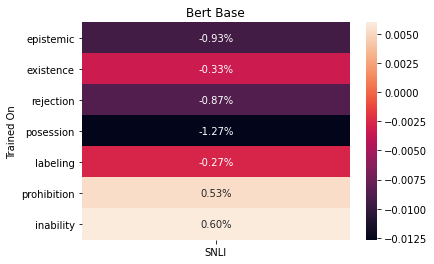

In [130]:
# now plot performance of finetuning on each negation type
from matplotlib import pyplot as plt
cols = ['epistemic','existence','rejection','posession', 'labeling', 'prohibition', 'inability']
#SNLI
c = 'SNLI'
dfs = [(epistemic,'epistemic'),(existence,'existence'),(rejection,'rejection'),(possession,'posession'),(labeling,'labeling'),(prohibition,'prohibition'),(inability,'inability')]
combined_df = pd.DataFrame()
for df in dfs:
    # df_acc = {'model':model,'trained_on':df[1],'epistemic':0,'existence':0,'rejection':0,'posession':0,'labeling':0,'prohibition':0,'inability':0}
    #SNLI
    df_acc = {'trained_on':df[1],'SNLI':0}
    #SNLI
    # for c in cols:
        # subset = df[0].loc[df[0][c] == 1]['Correct']
        # df_acc[c] = subset.sum() / len(subset)
    #SNLI
    subset = df[0]
    df_acc[c] = subset[subset['Correct'] == 1]['Correct'].sum() / len(subset)

        # compute delta acc
        # df_acc[c] = df_acc[c] - baseline_acc[c]
        #SNLI
    df_acc[c] = df_acc[c] - baseline_acc

    # if df_acc[c] > 0.05:
    #     df_acc[c] = 3
    # elif df_acc[c] < -0.05:
    #     df_acc[c] = -3
    # elif df_acc[c] <= 0.05 and df_acc[c] > 0.01:
    #     df_acc[c] = 2
    # elif df_acc[c] >= -0.05 and df_acc[c] < -0.01:
    #     df_acc[c] = -2
    # elif df_acc[c] <= 0.01 and df_acc[c] > 0.001:
    #     df_acc[c] = 1
    # elif df_acc[c] >= -0.01 and df_acc[c] < -0.001:
    #     df_acc[c] = -1
    # else:
    #     df_acc[c] = 0
    
    # combined_df = combined_df.append(pd.DataFrame(df_acc,index=[df[1]]))
    #SNLI
    combined_df = combined_df.append(pd.DataFrame(df_acc,index=[df[1]]))
    combined_df.drop(columns=["trained_on"],inplace=True)


ax = sns.heatmap(combined_df,annot=combined_df,fmt='.2%')
# ax.set_xlabel("Target")
ax.set_ylabel("Trained On")
ax.set_title("Bert Base")
plt.savefig("/home/antonio/from_source/negation-psycholinguistics/scripts/developmental-negation/graphs/bert-base-snli.png",dpi=300)

In [59]:
combined_df

,trained_on,SNLI
epistemic,epistemic,-2
existence,existence,-1
rejection,rejection,-2
posession,posession,-2
labeling,labeling,0
prohibition,prohibition,-1
inability,inability,-1


In [133]:
# get the json output
dfs = [(epistemic,'epistemic'),(existence,'existence'),(rejection,'rejection'),(possession,'posession'),(labeling,'labeling'),(prohibition,'prohibition'),(inability,'inability')]
cols = ['epistemic','existence','rejection','posession', 'labeling', 'prohibition', 'inability']
for df in dfs:
    df_acc = {'model':model,'trained_on':df[1],'epistemic':0,'existence':0,'rejection':0,'posession':0,'labeling':0,'prohibition':0,'inability':0}
    for c in cols:
        subset = df[0].loc[df[0][c] == 1]['Correct']
        df_acc[c] = subset.sum() / len(subset)
    
    # combined_df = combined_df.append(pd.DataFrame(df_acc,index=[df[1]]))
    combined_df = combined_df.append(df_acc,ignore_index=True)


# ax = sns.heatmap(combined_df,annot=combined_df,fmt='.2g')
combined_df = combined_df.append(baseline_acc,ignore_index=True)
combined_df

,epistemic,existence,inability,labeling,model,posession,prohibition,rejection,trained_on
0,0.933831,0.802113,0.787172,0.841837,bert-base-cased,0.848948,0.863049,0.769142,epistemic
1,0.811099,0.934678,0.793003,0.848639,bert-base-cased,0.845124,0.850129,0.765661,existence
2,0.807898,0.815562,0.795918,0.854592,bert-base-cased,0.845124,0.857881,0.912993,rejection
3,0.802561,0.810759,0.791545,0.839286,bert-base-cased,0.854685,0.824289,0.769142,posession
4,0.782284,0.804995,0.788630,0.985544,bert-base-cased,0.847036,0.826873,0.764501,labeling
...,...,...,...,...,...,...,...,...,...
67,0.862327,0.876081,0.855685,0.914966,xlnet-large-cased,0.959847,0.904393,0.849188,posession
68,0.864461,0.873199,0.860058,0.994048,xlnet-large-cased,0.902486,0.894057,0.848028,labeling
69,0.863394,0.876081,0.864431,0.916667,xlnet-large-cased,0.900574,0.984496,0.851508,prohibition
70,0.862327,0.874159,0.944606,0.915816,xlnet-large-cased,0.900574,0.909561,0.850348,inability


### Create smaller sets for models 1 and 2 in orthogonality experiment

In [27]:
import os
path = "/home/a/alaverghett/from_source/negation-psycholinguistics/scripts/developmental-negation/parse_nli/nli_datasets"
files = os.listdir(path)
files = [f for f in files if "train" in f and 'prohibition' not in f]
files = files[4:]
files

['posession_train_innoculation_v5.jsonl',
 'existence_train_innoculation_v5.jsonl',
 'labeling_train_innoculation_v5.jsonl',
 'inability_train_innoculation_v5.jsonl',
 'epistemic_train_innoculation_v5.jsonl',
 'rejection_train_innoculation_v5.jsonl']

In [28]:
import pandas as pd
from imblearn.under_sampling import RandomUnderSampler
# get undersampled subsets
for f in files:
    df = pd.read_json(path + "/" + f,lines=True,orient="records")
    if 'posession' in f:
        subset = df[df['gold_label']=='contradiction'].sample(n=349)
        df = df[df['gold_label'] != 'contradiction']
        df = df.append(subset)
        df['gold_label'].value_counts()
        df.to_json(path + "/" + f + "_undersampled",lines=True,orient="records")
    else:
        y = df["gold_label"]
        df.drop(columns="gold_label",inplace=True)
        # r = RandomUnderSampler(sampling_strategy='not minority')
        # df_res,y_res = r.fit_resample(df,y)
        r = RandomUnderSampler(sampling_strategy={'entailment':290,'contradiction':290,'neutral':234})
        df_res,y_res = r.fit_resample(df,y)
        df_res["gold_label"] = y_res
        df_res["gold_label"].value_counts()
        df_res.to_json(path + "/" + f + "_undersampled",lines=True,orient="records")

In [23]:
y.value_counts()

contradiction    580
neutral          172
entailment        62
Name: gold_label, dtype: int64

In [19]:
# create combined train set for the undersampled categories
path = "/home/antonio/from_source/negation-psycholinguistics/scripts/developmental-negation/parse_nli/nli_datasets/innoculation_sets"
files = os.listdir(path)
files = [f for f in files if "undersampled" in f or 'prohibition' in f and ('test' not in f and 'orthogonal' not in f)]
files.remove('nli_orthogonal_test_undersampled_model_3.json')
files
# df_combined = pd.DataFrame()
# for f in files:
#     df = pd.read_json(path + "/" + f,lines=True,orient='records')
#     df_combined = df_combined.append(df)

# len(df_combined)
# df_combined.to_json("/home/antonio/from_source/negation-psycholinguistics/scripts/developmental-negation/parse_nli/nli_datasets/nli_orthogonal_test_undersampled.json",lines=True,orient="records")

['prohibition_innoculation_v3.jsonl',
 'epistemic_innoculation_v3.jsonl_undersampled',
 'existence_innoculation_v3.jsonl_undersampled',
 'inability_innoculation_v3.jsonl_undersampled',
 'labeling_innoculation_v3.jsonl_undersampled',
 'posession_innoculation_v3.jsonl_undersampled',
 'rejection_innoculation_v3.jsonl_undersampled']

In [18]:
# create the train set for model 3 of experiment 2
import pandas as pd
path = "/home/antonio/from_source/negation-psycholinguistics/scripts/developmental-negation/parse_nli/nli_datasets/innoculation_sets"
files = os.listdir(path)
files = [f for f in files if "test" not in f and 'undersampled' not in f and ('labeling' in f or 'existence' in f or 'epistemic' in f)]
num_examples = 1009
df_combined = pd.DataFrame()
for f in files:
    if 'epistemic' in f:
        df = pd.read_json(path + "/" + f,lines=True,orient='records')
        df_combined = df_combined.append(df[df['gold_label'] == 'entailment'].sample(n=num_examples//3))
        df_combined = df_combined.append(df[df['gold_label'] == 'contradiction'].sample(n=num_examples//3))
        df_combined = df_combined.append(df[df['gold_label'] == 'neutral'].sample(n=num_examples//3))
    else:
        df = pd.read_json(path + "/" + f,lines=True,orient='records')
        df_combined = df_combined.append(df)

len(df_combined)
df_combined.to_json(path + "/" + "nli_orthogonal_test_undersampled_model_3.json",lines=True,orient="records")

In [2]:
# create the test set for experiment 2
import pandas as pd
path = "/home/antonio/from_source/negation-psycholinguistics/scripts/developmental-negation/parse_nli/nli_datasets/innoculation_sets"
files = os.listdir(path)
files = [f for f in files if "test" in f and 'undersampled' not in f]
files
# num_examples = 225
df_combined = pd.DataFrame()
for f in files:
    df = pd.read_json(path + "/" + f,lines=True,orient='records')
    df_combined = df_combined.append(df)

df_combined.to_json(path + "/" + "nli_orthogonal_test_model_3.json",lines=True,orient="records")

In [32]:
path = "/home/a/alaverghett/from_source/negation-psycholinguistics/scripts/developmental-negation/parse_nli/nli_datasets/"
files = os.listdir(path)
files = [f for f in files if "undersampled" in f or 'prohibition' in f and ('test' not in f and 'orthogonal' not in f)]
for f in files:
    df = pd.read_json(f"{path}/{f}",lines=True,orient="records")
    print(len(df))

814
782
814
814
814
814
814


### Get graph of results for curriculum experiments

In [3]:
import seaborn as sns
from matplotlib import pyplot as plt
import os
import pandas as pd

sns.set_theme()
model = 'bert-large-cased'
plt.rc('legend',fontsize=14)
plt.rc('axes',labelsize=16)
plt.rc('axes',titlesize=16)
plt.rc('xtick',labelsize=10)
plt.rc('ytick',labelsize=12)
pth = f'/home/a/alaverghett/from_source/negation-psycholinguistics/scripts/developmental-negation/checkpoint_results/bert-base-cased/epoch-10/experiment-3'
x = ['epistemic','existence','rejection','posession','labeling','prohibition','inability']
# cats = ['posession','existence','labeling','prohibition','inability','epistemic','rejection']
colors = ['#1f77b4', '#ff7f0e', '#d62728', '#8c564b', '#e377c2', '#bcbd22', '#17becf']
markers = ["d","h","s","*","^",".","None"]
model_1 = {
    'possession':[],
    'existence':[],
    'labeling':[],
    'prohibition':[],
    'inability':[],
    'epistemic':[],
    'rejection':[]
}

for i in x:
    for j in x:
        if j == 'posession':
            df = pd.read_csv(f"{pth}/{i}/epoch-10/challenge_nli_{j}_{model}.csv")
            model_1['possession'].append(df["Correct"].mean())
        else:
            df = pd.read_csv(f"{pth}/{i}/epoch-10/challenge_nli_{j}_{model}.csv")
            model_1[j].append(df["Correct"].mean())
# model_1 = {
#     "possession":[85.1,85.1,84.9,84.1,83.9,84.5,84.1],
#     "existence":[81.6,81.4,81.6,81.4,80.9,80.8,80.6],
#     "labeling":[85.5,85.1,85.1,84.5,87.1,87.3,87.1],
#     "prohibition":[84.2,84.5,83.2,83.2,83.2,93.3,93.8],
#     "inability":[79.9,79.2,79.3,78.9,78.7,79.2,78.7],
#     "epistemic":[80.1,79.8,79.6,78.9,78.4,78.5,78.2],
#     "rejection":[76.1,76.3,76.9,77.1,77.1,76.9,77.5],
# }
# model_2 = {
#     "epistemic":78.8,
#     "existence":78.2,
#     "rejection":74,
#     "possession":83.3,
#     "labeling":96.7,
#     "prohibition":97.7,
#     "inability":77
# }
# model_3 = {
#     "epistemic":78.2,
#     "existence":80.8,
#     "rejection":77,
#     "possession":84.5,
#     "labeling":96.9,
#     "prohibition":81.4,
#     "inability":79.4
# }
axes = []
for index,cat in enumerate(model_1.keys()):
    ax = plt.plot(x,model_1[cat],color=colors[index],marker=markers[index])
    axes.append(ax[0])

plt.ylabel("Accuracy")
plt.title("BERT Large")
plt.legend(axes,model_1.keys(),loc='best',bbox_to_anchor=(0.9,0.53,0.5,0.5))
plt.savefig("model_1-bert-large.png",dpi=300,bbox_inches="tight")

FileNotFoundError: [Errno 2] No such file or directory: '/home/antonio/from_source/negation-psycholinguistics/scripts/developmental-negation/checkpoint_results/orthogonality_test/bert-large-cased/orthoganlity-test-sequential/epistemic/epoch-10/challenge_nli_epistemic_bert-large-cased.csv'

In [27]:
import pandas as pd
df = pd.read_csv("/home/a/alaverghett/from_source/negation-psycholinguistics/scripts/developmental-negation/checkpoint_results/bert-large-cased/epoch-10/challenge_nli_dev_epoch-10.csv")
df["Correct"].sum()

8829